In [ ]:
#We would like to thanks the financial support of PAPIIT-IA104720

# HOG Facial recognition Notebook 

- Óscar A. Alvarado
- Oscar A. Esquivel

In [1]:
using Pkg
using Pkg
#Pkg.activate("/home/oscar/.julia/environments/HOG")
Pkg.activate("C:/Users/Óscar Alvarado/.julia/environments/HOG") # To use the correct environment

Activating new environment at `C:\Users\Óscar Alvarado\.julia\environments\HOG\Project.toml`


In [24]:
using Images, ImageFeatures # We have to Pkg.add("Netpbm") because our images are in pgm format
using DataFrames, CSV
using LinearAlgebra
using BenchmarkTools

In [15]:
marco = 20

20

- Loading training faces

In [16]:
tensor = zeros(18, 192 + 2marco, 168 + 2marco)
path = "../datasets/CroppedYale/"
i = 1
for directory = readdir(path)
    if occursin("yale", directory) && Meta.parse(directory[end-1:end]) < 20
        for file in readdir(path*directory)
            if occursin("-005E-10", file)
                println(path*directory*"/"*file)
                tensor[i, marco:(192+marco-1), marco:(168+marco-1)] = Float64.(load(path*directory*"/"*file))
                i += 1
            end
        end
    end
end

../datasets/CroppedYale/yaleB01/yaleB01_P00A-005E-10.pgm
../datasets/CroppedYale/yaleB02/yaleB02_P00A-005E-10.pgm
../datasets/CroppedYale/yaleB03/yaleB03_P00A-005E-10.pgm
../datasets/CroppedYale/yaleB04/yaleB04_P00A-005E-10.pgm
../datasets/CroppedYale/yaleB05/yaleB05_P00A-005E-10.pgm
../datasets/CroppedYale/yaleB06/yaleB06_P00A-005E-10.pgm
../datasets/CroppedYale/yaleB07/yaleB07_P00A-005E-10.pgm
../datasets/CroppedYale/yaleB08/yaleB08_P00A-005E-10.pgm
../datasets/CroppedYale/yaleB09/yaleB09_P00A-005E-10.pgm
../datasets/CroppedYale/yaleB10/yaleB10_P00A-005E-10.pgm
../datasets/CroppedYale/yaleB11/yaleB11_P00A-005E-10.pgm
../datasets/CroppedYale/yaleB12/yaleB12_P00A-005E-10.pgm
../datasets/CroppedYale/yaleB13/yaleB13_P00A-005E-10.pgm
../datasets/CroppedYale/yaleB15/yaleB15_P00A-005E-10.pgm
../datasets/CroppedYale/yaleB16/yaleB16_P00A-005E-10.pgm
../datasets/CroppedYale/yaleB17/yaleB17_P00A-005E-10.pgm
../datasets/CroppedYale/yaleB18/yaleB18_P00A-005E-10.pgm
../datasets/CroppedYale/yaleB19

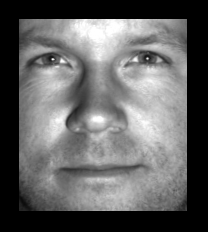

In [17]:
Gray.(tensor[3,:,:]) # We have to Pkg.add("ImageMagick") to see the image

- loading the landmarks' coordinates

In [18]:
landmarks_train = DataFrame(CSV.File("../datasets/CroppedYale/coords_15_landmarks.csv"))
# We have to move "marco" pixels in x and y axis because the black background

,ojo_i-x,ojo_i-y,ojo_d-x,ojo_d-y,nariz_frente-x,nariz_frente-y,lagrimal_i-x
,Int64,Int64,Int64,Int64,Int64,Int64,Int64
1,35,45,129,45,80,40,55
2,37,44,133,44,82,36,56
3,32,39,128,39,78,40,52
4,39,48,133,47,84,40,61
5,35,50,130,50,82,49,54
6,36,47,132,48,83,36,59
7,33,50,130,51,80,45,56
8,36,41,131,42,83,40,58
9,34,50,131,51,82,43,58


- getting HOG features of the landmarks using a 20 $\times$ 20 window. 

The pixel's coordinates have to be the center of the window (actually, is the (10,10) pixel, we don't have a center here).

In [19]:
HOG(orientations = 8, cell_size = 4, block_size = 1, block_stride = 1, norm_method = "L2-norm")

HOG(8, 4, 1, 1, "L2-norm")

In [20]:
HOG() = HOG(orientations = 8, cell_size = 4, block_size = 1, block_stride = 1, norm_method = "L2-norm")

HOG

In [21]:
w_size = 28

28

In [38]:
function make_fgb(landmarks_train, tensor, marco, w_size)
    FGB = Dict()
    columns = names(landmarks_train)
    for idx = 1:size(tensor)[1]
        FGB["$idx"] = Dict()
        for (idx2, name) = enumerate(columns[1:2:end])
            FGB["$idx"]["$(name[1:end-2])"] = Dict("X" => [landmarks_train[idx, columns[2idx2]] + marco + 1, landmarks_train[idx, columns[2idx2-1]] + marco + 1],
            "J" => create_descriptor(tensor[idx, landmarks_train[idx, columns[2idx2]] + marco + 1 - Int(w_size/2):landmarks_train[idx, columns[2idx2]] + marco + Int(w_size/2),
                landmarks_train[idx, columns[2idx2-1]] + marco + 1 - Int(w_size/2):landmarks_train[idx, columns[2idx2-1]] + marco + Int(w_size/2)], HOG()))
        end
    end
    return FGB
end

make_fgb (generic function with 1 method)

In [42]:
FGB = make_fgb(landmarks_train, tensor, marco, w_size);

- location of facial landmarks 

1.- Initial estimation of the facial landmark location, $X^{s}_{i}$. This estimate is based on the mean of displacements between the i-th keypoint and the j-th (j<i) keypoints 

2.- Calculate the HOG descriptor on the previous location, HOG($X^{s}_{i}$).

In [33]:
function d(var_i, var_j, FGB)
    x, y = 0, 0
    for key = keys(FGB)
        x += (FGB[key][var_i]["X"] - FGB[key][var_j]["X"])[2]
        y += (FGB[key][var_i]["X"] - FGB[key][var_j]["X"])[1]
    end
    d = [x, y] ./ length(keys(FGB))
    return d
end

function X_s(x_j, var_i, var_j, FGB)
    x = d(var_i, var_j, FGB)
    X =  x_j + [x[2], x[1]]
    return X
end 

function estimate_landmarks(img, coord_eyes, w_size, marco, FGB)
    img_dic = Dict("ojo_i" => Dict("X" => coord_eyes[1:2] .+ 1, 
            "J" => create_descriptor(img[coord_eyes[2] - Int(w_size/2) + 1:coord_eyes[2] + Int(w_size/2), coord_eyes[1] - Int(w_size/2) + 1:coord_eyes[1] + Int(w_size/2)], HOG())), 
                    "ojo_d" => Dict("X" => coord_eyes[3:4] .+ 1,
            "J" => create_descriptor(img[coord_eyes[4] - Int(w_size/2) + 1:coord_eyes[4] + Int(w_size/2), coord_eyes[3] - Int(w_size/2) + 1:coord_eyes[3] + Int(w_size/2)], HOG())))

    chars_order = ["ojo_i", "ojo_d", "nariz_frente", "lagrimal_i", "lagrimal_d", "ceja1_i", "ceja1_d", 
                    "ceja2_i", "ceja2_d", "nariz1", "nariz2", "nariz3", "boca1", "boca2", "boca3"]
    
    for count in 3:length(chars_order)
        X_1, X_2 = 0, 0
        for char in 1:count-1
            X_1 += X_s(img_dic[chars_order[char]]["X"], chars_order[count], chars_order[char], FGB)[1]
            X_2 += X_s(img_dic[chars_order[char]]["X"], chars_order[count], chars_order[char], FGB)[2]
        end
        X = round.(Int, [X_2, X_1] ./ (count - 1))
        if X[1] < marco
            X[1] = marco
        elseif X[1] > size(img)[1] - marco
            X[1] = size(img)[1] - marco
        elseif X[2] < marco
            X[2] = marco
        elseif X[2] > size(img)[1] - marco
            X[2] = size(img)[1] - marco
        end
        img_dic[chars_order[count]] = Dict("X" => X,
                        "J" => create_descriptor(img[X[2] - Int(w_size/2) + 1:X[2] + Int(w_size/2), X[1] - Int(w_size/2) + 1:X[1] + Int(w_size/2)], HOG()))
    end
    return img_dic
end

estimate_landmarks (generic function with 2 methods)

3.- Compare HOG($X^{s}_{i}$) with the $fbg_{i}(k)$, $0 \leq k \leq N_{f}$ in the FBG and let:

$$
k_{min} = min_{k}||HOG(X^{s}_{i}) - fbg_{i}(k)||
$$

In [34]:
chars_order = ["ojo_i", "ojo_d", "nariz_frente", "lagrimal_i", "lagrimal_d", "ceja1_i", "ceja1_d", 
                    "ceja2_i", "ceja2_d", "nariz1", "nariz2", "nariz3", "boca1", "boca2", "boca3"];

function get_kmin(test_dic, FGB, chars_order)
    k_min = Dict()
    for char = chars_order 
        k_min[char] = argmin(norm.([each_FGB_elmt - test_dic[char]["J"] for each_FGB_elmt = [FGB["$llave"][char]["J"] for llave = sort(Meta.parse.(collect(keys(FGB))))]]))
    end
    return k_min
end

get_kmin (generic function with 1 method)

4.- Define a search area $S_{i}$ around $X^{s}_{i}$. The extent of the search area depends on the particular keypoint. "We empirically set the search areas considering the dispersion of the location of facial landmarks in the FBG for eachkeypoint".

5.- Refine the initial estimate of the _i_-th keypoint using the descriptor $fbg_{i}(k_{min})$:

$$
X_{i} = min_{X \in S_{i}} ||HOG(X) - fbg_{i}(k_{min})||
$$

In [35]:
function refine_dic(FGB, test_dic, img_test, k_min, w_size, chars_order)
    s_area = Dict("ojo_i" => [0:0, 0:0],
                "ojo_d" => [0:0, 0:0],
                "nariz_frente" => [0:3, 1:-1:-4],
                "lagrimal_i" => [-1:4, 2:-1:-3],
                "lagrimal_d" => [-2:3, 4:-1:-1],
                "ceja1_i" => [-1:5, 4:-1:-2],
                "ceja1_d" => [-5:2, 5:-1:-2],
                "ceja2_i" => [0:0, 0:0],# The image has no space to move the window
                "ceja2_d" => [0:0, 0:0], # The image has no space to move the window
                "nariz1" => [-1:4, 6:-1:-6],
                "nariz2" => [-1:4, 6:-1:-5],
                "nariz3" => [-1:4, 6:-1:-5],
                "boca1" => [-2:0, 6:-1:-6],
                "boca2" => [-2:7, 4:-1:-2],
                "boca3" => [-6:4, 1:-1:-4]);
    
    for char = chars_order
        min_s = []
        min_x = []
        for j = s_area[char][2]
            for i = s_area[char][1]
                push!(min_s, norm(create_descriptor(img_test[(test_dic[char]["X"][2] + j - Int(w_size/2) + 1):(test_dic[char]["X"][2] + j + Int(w_size/2)),
                    (test_dic[char]["X"][1] + i - Int(w_size/2) + 1):(test_dic[char]["X"][1] + i + Int(w_size/2))], HOG()) - FGB["$(k_min[char])"][char]["J"]))
                push!(min_x, round.(Int, [test_dic[char]["X"][1] + i, test_dic[char]["X"][2] + j]))
            end
        end
        a_min = argmin(min_s)
        test_dic[char]["X"] = min_x[a_min]
        test_dic[char]["J"] = create_descriptor(img_test[test_dic[char]["X"][2] - Int(w_size/2) + 1:test_dic[char]["X"][2] + Int(w_size/2),
                                test_dic[char]["X"][1] - Int(w_size/2) + 1:test_dic[char]["X"][1] + Int(w_size/2)],HOG())
    end
    return test_dic
end

refine_dic (generic function with 1 method)

- comparing two face graphs

To compare two face graphs $FG^{k}$ and $FG^{l}$ from two different faces, we just sum up the distances between corresponding key-point descriptors $J^{k}_{i}$ and $J^{l}_{i}$:

$$
D_{kl} = |FG^{k},FG^{l}| = \sum ^{15}_{i=1}||J^{k}_{i} - J^{l}_{i}||
$$

In [45]:
path = "../datasets/CroppedYale/"
images = ["yaleB01/yaleB01_P00A-020E-10.pgm", "yaleB02/yaleB02_P00A-010E+00.pgm", "yaleB03/yaleB03_P00A-010E+00.pgm",
        "yaleB04/yaleB04_P00A-010E-20.pgm", "yaleB05/yaleB05_P00A-010E+00.pgm", "yaleB06/yaleB06_P00A-010E+00.pgm",
        "yaleB07/yaleB07_P00A-010E+00.pgm", "yaleB08/yaleB08_P00A-010E+00.pgm", "yaleB09/yaleB09_P00A-010E+00.pgm",
        "yaleB10/yaleB10_P00A-010E+00.pgm", "yaleB11/yaleB11_P00A-010E+00.pgm", "yaleB12/yaleB12_P00A-010E+00.pgm",
        "yaleB13/yaleB13_P00A-010E+00.pgm", "yaleB15/yaleB15_P00A-010E+00.pgm", "yaleB16/yaleB16_P00A-020E+10.pgm",
        "yaleB17/yaleB17_P00A-005E+10.pgm", "yaleB18/yaleB18_P00A-010E-20.pgm", "yaleB19/yaleB19_P00A-010E+00.pgm"]
coord_tests = [43 55 138 55;46 53 142 55;42 49 138 48;47 56 141 56;44 59 140 59;44 57 142 56;43 60 139 61;
            45 51 141 52;42 59 141 59;46 49 141 50;46 59 145 61;43 50 138 51;54 45 154 48;43 58 143 60;
            43 60 140 61;45 59 142 56; #,93,51,67,65,121,63,109,41,68,41,31,29,158,23,96,123,65,114,126,109,97,153,65,160,137,156]
            40 47 141 48;44 63 138 64] .+ marco .- 10
var = 1
img_test = zeros(192 + 2marco, 168 + 2marco)
img_test[marco:(192+marco-1), marco:(168+marco-1)], coord_test = load(path*images[var]), coord_tests[var,:]
test_dic = estimate_landmarks(img_test, coord_test, w_size, marco, FGB)
k_min = get_kmin(test_dic, FGB, chars_order)
test_dic = refine_dic(FGB, test_dic, img_test, k_min, w_size, chars_order);

In [46]:
min = Inf
face = ""
for key in keys(FGB)
    D = sum([norm(test_dic[char]["J"] - FGB[key][char]["J"]) for char in chars_order])
    @show key, D
    if D <= min
        min = D
        face = key
    end
end
face

(key, D) = ("4", 87.00112390746435)
(key, D) = ("1", 81.13467417209425)
(key, D) = ("12", 93.31234818813037)
(key, D) = ("2", 90.23393026482901)
(key, D) = ("6", 93.29654653487793)
(key, D) = ("11", 92.99600234111884)
(key, D) = ("13", 93.16334270745247)
(key, D) = ("5", 91.34816943374071)
(key, D) = ("15", 88.40644584713692)
(key, D) = ("16", 87.7965228862327)
(key, D) = ("14", 90.37680212183783)
(key, D) = ("7", 90.88460176934353)
(key, D) = ("8", 90.72420950239203)
(key, D) = ("17", 89.88839027196289)
(key, D) = ("10", 89.5810877793765)
(key, D) = ("9", 88.38917975477976)
(key, D) = ("18", 89.92898321758798)
(key, D) = ("3", 86.55953523322522)


"1"